# YIELDS.IO | Stress Testing with GANs 
---------------------
Testing out GAN model with the PPNR dataset
---------------
- **Step 0:** Mount directory of Google drive (for use in G Colab). Import libraries, GAN functions, and Dataset
- **Step 1:** Preproccesing 
- **Step 2:** Implement a composite GAN NN
- **Step 3:** Train the GAN NN 
- **Step 4:** Evaluate Performance 

## STEP 0: IMPORT NEEDED DATA
--------
### Google Colab Directory

(Run only when used on Google Colab)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive/Stress Testing with GANs')

### Import all the functions of the main notebook (including libraries)
--------------

In [ ]:
from GAN_functions import *

In [ ]:
# Import specific libraries 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

### Import PPNR Dataset 
------------------
- Run either the Jupyter Notebook cell OR the Google Colab cell depending on which environment you're utilizing 

#### Jupyter Notebook on local environment 

In [ ]:
#import dataset
ppnr = pd.read_csv(r'C:\Users\ilias\Desktop\Statistics and Data Science\Jupyter Notebook\Yields.io\Stress Testing with GAN\ppnr_GAN.csv')

#### Google Colab when importing dataset from local environment  

In [ ]:
# Import files module 
from google.colab import files
# Upload PPNR dataset into GColab 
ppnr = files.upload()
# Read the file
import io
ppnr = pd.read_csv(io.BytesIO(ppnr['ppnr_GAN.csv']))
# Convert to the right data type 
ppnr = ppnr.astype(dtype = 'float64') 

#### Google Colab when importing dataset directly from Google Drive


In [ ]:
# Code to read csv file into Colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Shareable link from the dataset in Google drive 
link= 'https://drive.google.com/file/d/1sA6D4efL8WWkUtkRScH71LllOqoA8a5a/view?usp=sharing'
#we only need the id-key portion of the link
id= '1sA6D4efL8WWkUtkRScH71LllOqoA8a5a'

# Import dataset
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ppnr_GAN.csv')  
ppnr = pd.read_csv('ppnr_GAN.csv')

#### Quick overview 

In [ ]:
# Missing values 
print('Missing values:', ppnr.isnull().values.any())
# Quick overview
display(ppnr.head())

Missing values: False


,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION,LIMIT_BAL,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX,default_payment_next_month
0,24,3913.0,3102.0,689.0,0.0,0.0,0.0,2,20000.0,1,2,2,-1,-1,-2,-2,0.0,689.0,0.0,0.0,0.0,0.0,2,1
1,26,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,2,120000.0,2,-1,2,0,0,0,2,0.0,1000.0,1000.0,1000.0,0.0,2000.0,2,1
2,34,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,2,90000.0,2,0,0,0,0,0,0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,2,0
3,37,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,1,50000.0,2,0,0,0,0,0,0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,1,0
4,29,367965.0,412023.0,445007.0,542653.0,483003.0,473944.0,1,500000.0,2,0,0,0,0,0,0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,1,0


## STEP 1: PREPROCCESING 
--------------
### Separate data into continuous and nominal data 

In [ ]:
# Store column names 
continuousColumns= ['AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                   'LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',]
nominalColumns= ['EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                  'SEX', 'default_payment_next_month']

# Nominal data 
datasetNominal= ppnr[nominalColumns]

# Continuous data (including ordinal data)
datasetContinuous= ppnr.drop(labels=nominalColumns, axis= 1)

# Get number of categorical values of each nominal variable 
nominalColumnsValues= datasetNominal.nunique().values

### Preprocess nominal data 
------------------

#### One-hot encoding (dummy variables) 
--------------

In [ ]:
nameFeatures = nominalColumns
ohe = OneHotEncoder(sparse= False) #create encoder object 
datasetEncoded = ohe.fit_transform(datasetNominal) #transform nominal data 
datasetEncoded = pd.DataFrame(datasetEncoded) #transform output to df 
datasetEncoded.columns = ohe.get_feature_names(nameFeatures) #name columns appropriately 

#### Add noise and normalize 
-----------------

In [ ]:
# Create noise 
noise = np.random.uniform(0, 0.2, datasetEncoded.shape) #noise level of 0.2 is the standard 
# Add noise to dataset 
dataset_with_noise = datasetEncoded.values + noise 

# Normalize each variable separately (from ohe to probabilities)
datasetNominalNormalized = np.array([]).reshape(len(dataset_with_noise), -1) #initialize 
variablesSeparated= variableSeparator(nominalColumnsValues = nominalColumnsValues, nominalDataset= dataset_with_noise)
for eachVariable in variablesSeparated: 
    tmp= ( eachVariable / np.sum(eachVariable, axis= 1)[:, None] )
    datasetNominalNormalized= np.concatenate( (datasetNominalNormalized, tmp), axis= 1)

### Preprocess continuous data 
------------------

#### Normalize the data from original distribution to [-1, 1] 


In [ ]:
maximum = np.max(datasetContinuous)
minimum = np.min(datasetContinuous)
datasetContinuousNormalized= ( 2 * (datasetContinuous - minimum) / (maximum - minimum) - 1 )

### Choose dataset to work with 
-------------


In [ ]:
dataset= np.concatenate((datasetContinuousNormalized, datasetNominalNormalized), axis=1) 

## STEP 2: SETUP GAN MODEL
---------------
- Choose between the Vanilla GAN and the WGAN-GP 

#### GAN 
--------

In [ ]:
## DISCRIMINATOR

# Shape of the dataset 
input_shape= dataset.shape[1]
# Create the discriminator
discriminator = discriminator_setup_CTGAN(input_shape)

## GENERATOR 

# Shape of the latent space of the generator 
latent_dim= 100 #used in many papers 
# create the generator
generator = generator_setup_CTGAN(input_shape, latent_dim,)

## GAN

# create the gan
gan_model = gan_setup(generator, discriminator)

#### WGAN-GP
---------



In [ ]:
# Training parameters 
epochs= 10000
batch_size= 512
noise_dim= 512
discriminator_steps= 5
# Compile model 
d_model, g_model, wgan= compile_wgan(dataset_dim= dataset.shape[1], dataset_nominal_dim= nominalColumnsValues, 
            dataset_continuous_dim= datasetContinuousNormalized.shape[1], nominalColumns= nominalColumns,
            epochs= epochs, noise_dim= noise_dim, batch_size= batch_size, discriminator_steps= discriminator_steps)

# Custom callback to get KL-divergence during training
cbk= GANMonitor(Xreal= dataset, sample_size= 1000, latent_dim= batch_size, k= 10)

## STEP 3: TRAIN GAN
-----------------
- Choose between the Vanilla GAN and the WGAN-GP 

#### BASIC GAN 

In [ ]:
## Train model
n_epochs= 10
batch_size= len(dataset)
train_gan(discriminator, generator, gan_model, dataset, latent_dim, n_epochs, batch_size,True,
     'desktop') #saves generator after every epoch 

#### WGAN-GP


In [ ]:
## Train model
history = wgan.fit(x= dataset, batch_size= batch_size, epochs= epochs, callbacks= [cbk])

## Save Generator
!mkdir -p saved_model
g_model.save('/content/gdrive/My Drive/Stress Testing with GANs/generator_model')

Streaming output truncated to the last 5000 lines.
Epoch 7502/10000
15/15 [==============================] - 1s 43ms/step - d_loss: -0.0192 - g_loss: 0.1868
Epoch 7503/10000
15/15 [==============================] - 1s 42ms/step - d_loss: -0.0185 - g_loss: 0.1693
Epoch 7504/10000
15/15 [==============================] - 1s 42ms/step - d_loss: -0.0243 - g_loss: 0.1176
Epoch 7505/10000
15/15 [==============================] - 1s 41ms/step - d_loss: -0.0104 - g_loss: 0.1209
Epoch 7506/10000
15/15 [==============================] - 1s 41ms/step - d_loss: -0.0136 - g_loss: 0.1438
Epoch 7507/10000
15/15 [==============================] - 1s 42ms/step - d_loss: -0.0207 - g_loss: 0.1003
Epoch 7508/10000
15/15 [==============================] - 1s 41ms/step - d_loss: -0.0171 - g_loss: 0.1707
Epoch 7509/10000
15/15 [==============================] - 1s 44ms/step - d_loss: -0.0152 - g_loss: 0.1696
Epoch 7510/10000
15/15 [==============================] - 1s 42ms/step - d_loss: -0.0228 - g_loss: 0.

In [ ]:
## Loss functions and KL-divergence 
plot_metrics(history=history, cbk= cbk, zoom_in= True)

### Load previous trained model (if applicable)
------------
Choose between local environment OR Google Drive 

#### Load model saved in local environment (change path to desired model) 

In [ ]:
g_model = tf.keras.models.load_model(r'C:\Users\ilias\Desktop\Statistics and Data Science\Jupyter Notebook\Yields.io\Stress Testing with GAN\generator_model_v2')

#### Load model saved in Google Drive 

In [ ]:
g_model = tf.keras.models.load_model(r'/content/gdrive/My Drive/Stress Testing with GANs/generator_model') 

## STEP 4: POSTPROCESSING 
----------------

#### Generate a set of Real and Artificial data 
-------------

In [ ]:
n_samples= 10000 #number of samples to draw
Xfake, _= generate_artificial_samples(g_model, noise_dim, n_samples) #synthetic samples from trained Generator
Xreal, _= generate_real_samples(dataset, n_samples) #real samples from original dataset

#### KL-Divergence (with larger sample size) 
-----------

In [ ]:
print('Estimated KL-divergence:', KLdivergence(Xreal, Xfake, k=10))

Estimated KL-divergence: 0.8293706315231689


### Separate Datasets into Continuous and Nominal data  
------------------

In [ ]:
# Dimensions 
dimContinuous= len(continuousColumns)
dimNominal= len(nominalColumns)

# Artificial Dataset 
Xfake_continuous= Xfake[:,0:dimContinuous] 
Xfake_nominal= Xfake[:, dimContinuous:]

# Real Dataset 
Xreal_continuous= Xreal[:, 0:dimContinuous]
Xreal_nominal= Xreal[:, dimContinuous:]

#### Reprocess the Nominal data 
---------------

### Transform data from probabilities to One-hot encoding format 
-----------

In [ ]:
# Divide datasets into separated columns for each nominal variable
XrealSeparated= variableSeparator(nominalColumnsValues = nominalColumnsValues, nominalDataset= Xreal_nominal)
XfakeSeparated= variableSeparator(nominalColumnsValues = nominalColumnsValues, nominalDataset= Xfake_nominal)

# Transform columns into one-hot encoding format
Xreal_transformed= []
Xfake_transformed= []
for eachVariable in XrealSeparated:
    tmp= retransformer(eachVariable)
    Xreal_transformed.append(tmp)
for eachVariable in XfakeSeparated:
    tmp= retransformer(eachVariable)
    Xfake_transformed.append(tmp)

# Concatenate back into one dataset
Xreal_nominal = np.concatenate((Xreal_transformed), axis=1)
Xfake_nominal = np.concatenate((Xfake_transformed), axis=1)

#### Reprocess the Continuous data
--------------
- Renormalize the data from [-1, 1] to original shape

In [ ]:
# Real dataset
Xreal_continuous_renormalized= ( ((Xreal_continuous + 1) / 2) * (maximum[:, None].T - minimum[:, None].T) 
                                + minimum[:, None].T)
# Synthetic dataset
Xfake_continuous_renormalized= ( ((Xfake_continuous + 1) / 2) * (maximum[:, None].T - minimum[:, None].T) 
                                + minimum[:, None].T)
Xfake_continuous_renormalized=  np.round(Xfake_continuous_renormalized) #original variables are all integers (WIP)

#### Merge all reprocessed data into final matrix

------------

In [ ]:
# Real dataset
Xreal= np.concatenate( (Xreal_continuous_renormalized, Xreal_nominal), axis= 1)
# Artificial dataset 
Xfake= np.concatenate( (Xfake_continuous_renormalized, Xfake_nominal), axis= 1)

## STEP 5: EVALUATE PERFORMANCE
-----------------------


#### Plot the continuous marginal densities of the real adn synthetic data
------------
- Left: probability densities 
- Right: cumulative denstities 


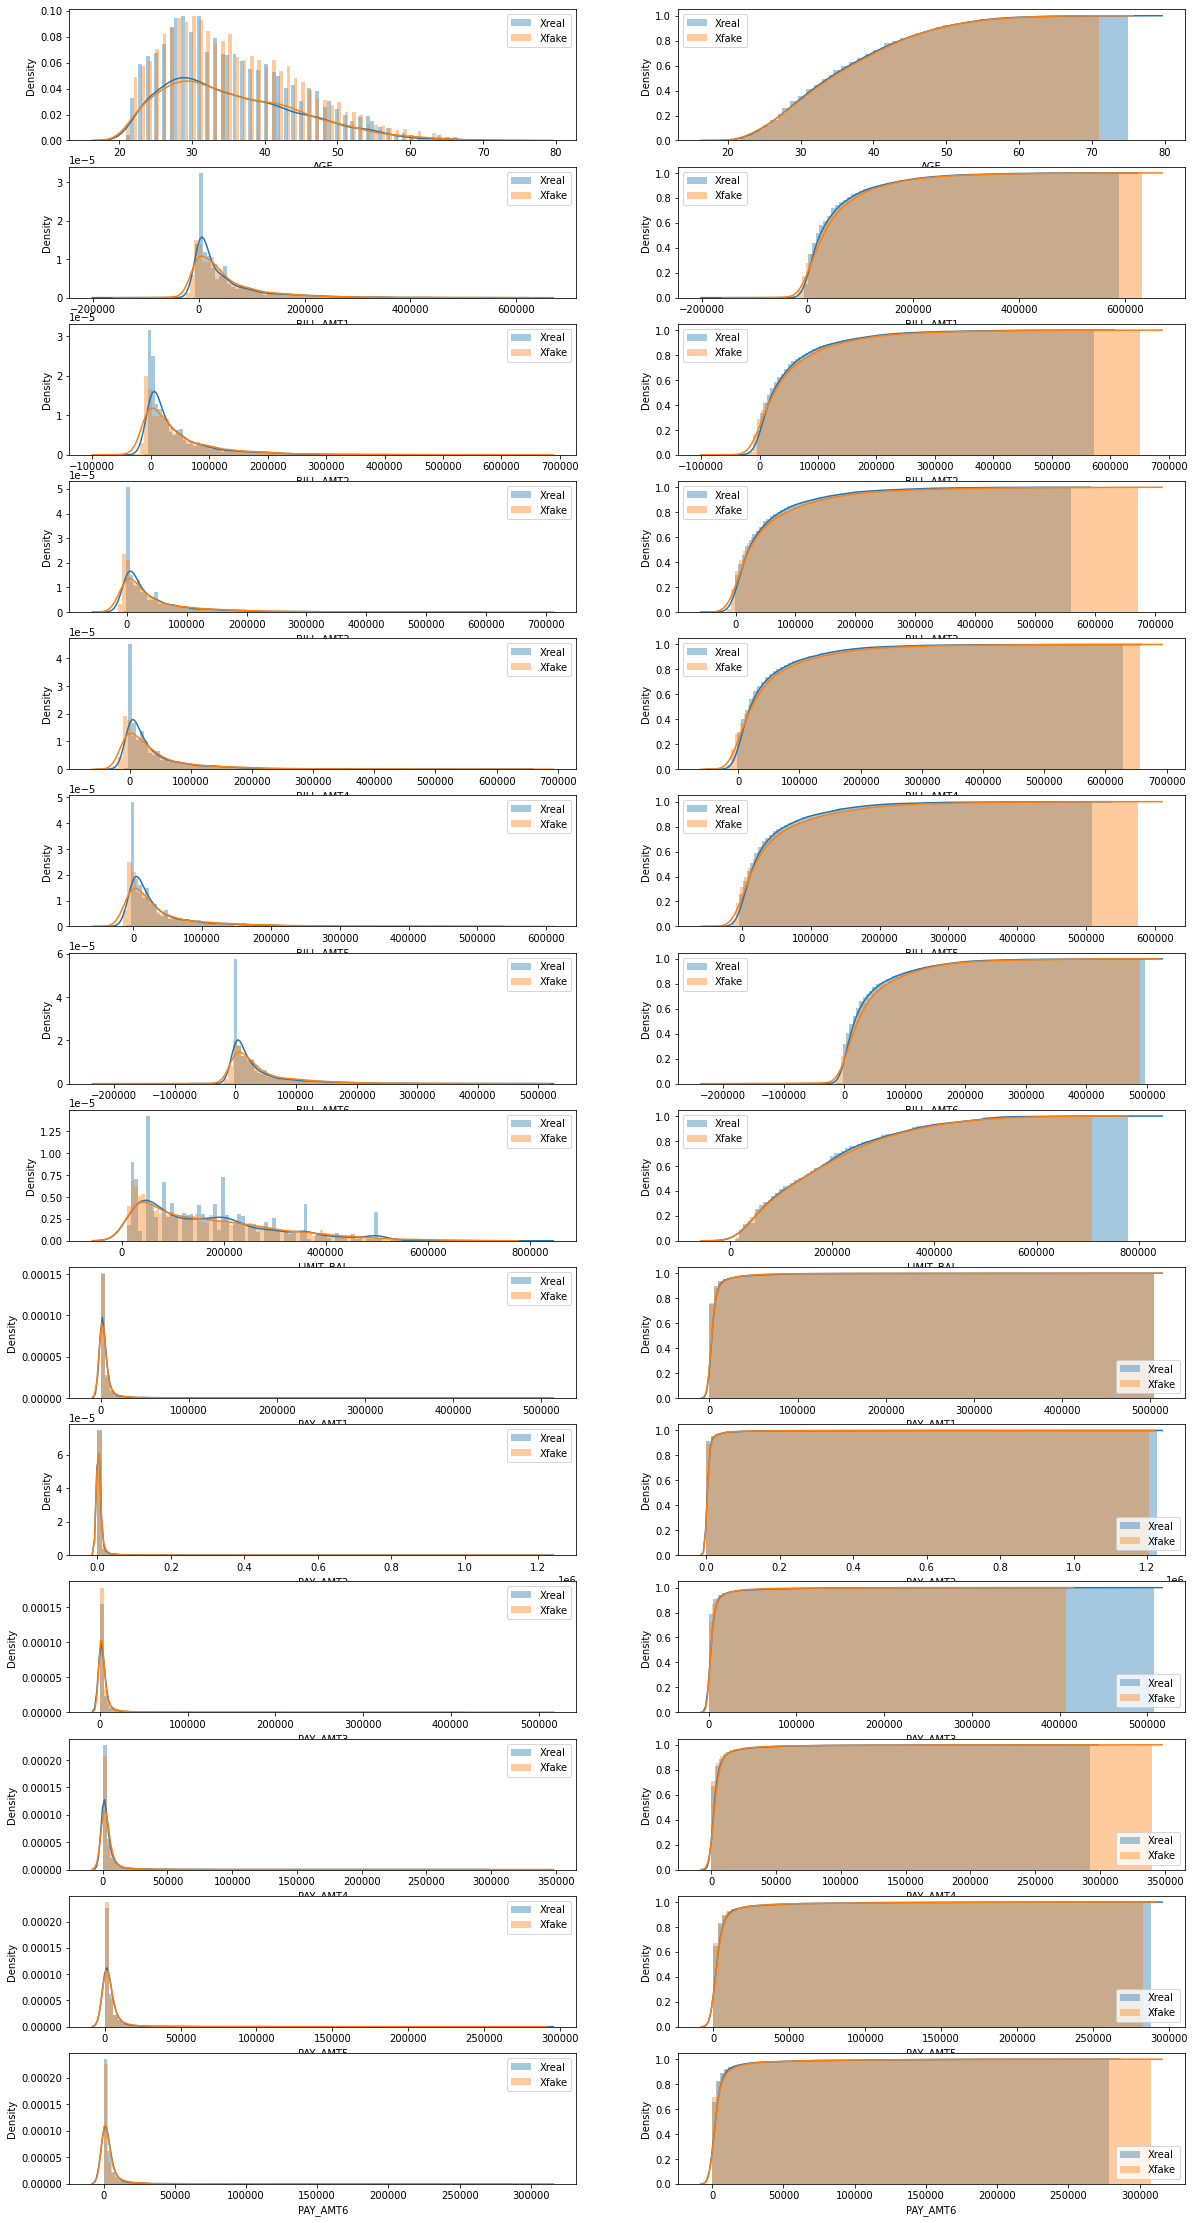

In [ ]:
# Initialzie plot 
dim= Xreal_continuous_renormalized.shape[1]
idx_Xreal= np.arange(1,dim*2,2)
idx_Xfake= np.arange(2,dim*2+2,2)
fig= plt.figure(figsize=[20,40])

# Plot the marginals 
for eachVariable in range(dim):
  
  # Probability densities 
  plt.subplot(dim, 2, idx_Xreal[eachVariable])
  sns.distplot(Xreal_continuous_renormalized[:,eachVariable], bins= 100, label= 'Xreal')
  sns.distplot(Xfake_continuous_renormalized[:,eachVariable], bins= 100, label= 'Xfake')
  plt.xlabel(continuousColumns[eachVariable], fontsize = 10)
  plt.legend();

  # Cumulative denstities 
  plt.subplot(dim, 2, idx_Xfake[eachVariable])
  kwargs = {'cumulative': True}
  sns.distplot(Xreal_continuous_renormalized[:,eachVariable], bins= 100, label= 'Xreal', hist_kws=kwargs, kde_kws=kwargs)
  sns.distplot(Xfake_continuous_renormalized[:,eachVariable], bins= 100, label= 'Xfake', hist_kws=kwargs, kde_kws=kwargs)
  plt.xlabel(continuousColumns[eachVariable], fontsize = 10)
  plt.legend();

In [ ]:
#### TEST TEST TEST TEST TEST ##############
#ignore for now please 
from scipy.stats import anderson_ksamp as adTest
adTest([Xreal_continuous_renormalized[:, 0], Xfake_continuous_renormalized[: ,0]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: p-value floored: true value smaller than 0.001
  This is separate from the ipykernel package so we can avoid doing imports until


Anderson_ksampResult(statistic=25.865539549686734, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

In [ ]:
# Check number of zero values 
print("Xreal -> number of zero values:", np.sum(Xreal_continuous_renormalized[:,1] == 0))
print("Xfake -> number of zero values:", np.sum(Xfake_continuous_renormalized[:,1] == 0))

Xreal -> number of zero values: 757
Xfake -> number of zero values: 0


### Correlations between continuous variables 
----------

In [ ]:
# -----------------------------------------
# Pearson Lienear Correlation coefficient
# -----------------------------------------

# Correlation structure within the real dataset 
Xreal_corr= pd.DataFrame(data= np.round(np.corrcoef(Xreal_continuous_renormalized, rowvar= False), 2), 
                         columns=continuousColumns,
                        index= continuousColumns)

# Correlation structure within the fake dataset 
Xfake_corr= pd.DataFrame(data= np.round(np.corrcoef(Xfake_continuous_renormalized, rowvar= False), 2), 
                         columns=continuousColumns,
                        index= continuousColumns)

# Difference in correlation structure between the datasets 
X_corr_diff= Xreal_corr - Xfake_corr
X_corr_diff

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,LIMIT_BAL,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
AGE,0.00,-0.04,-0.05,-0.06,-0.04,-0.04,-0.02,0.04,0.00,-0.02,0.02,-0.02,-0.01,0.00
BILL_AMT1,-0.04,0.00,-0.01,-0.01,-0.02,-0.02,-0.01,0.04,0.01,-0.05,-0.08,-0.09,0.00,-0.04
BILL_AMT2,-0.05,-0.01,0.00,0.00,-0.02,-0.03,-0.03,0.02,-0.01,-0.03,-0.05,-0.10,0.01,-0.05
BILL_AMT3,-0.06,-0.01,0.00,0.00,-0.02,-0.02,0.01,0.00,0.02,-0.03,-0.01,-0.08,0.02,-0.04
BILL_AMT4,-0.04,-0.02,-0.02,-0.02,0.00,-0.01,0.02,0.02,0.00,-0.08,-0.03,-0.09,0.02,-0.04
BILL_AMT5,-0.04,-0.02,-0.03,-0.02,-0.01,0.00,-0.01,0.01,-0.05,-0.06,-0.02,-0.10,0.00,-0.02
BILL_AMT6,-0.02,-0.01,-0.03,0.01,0.02,-0.01,0.00,0.03,-0.04,-0.02,0.00,-0.11,-0.03,-0.09
LIMIT_BAL,0.04,0.04,0.02,0.00,0.02,0.01,0.03,0.00,-0.01,0.00,0.04,-0.01,0.03,0.03
PAY_AMT1,0.00,0.01,-0.01,0.02,0.00,-0.05,-0.04,-0.01,0.00,0.14,0.05,-0.06,0.01,-0.03
PAY_AMT2,-0.02,-0.05,-0.03,-0.03,-0.08,-0.06,-0.02,0.00,0.14,0.00,0.12,0.00,0.04,-0.04


In [ ]:
# Frobenius norm of real dataset covariance matrix
Xreal_fro= np.linalg.norm(Xreal_corr, ord= 'fro')
# Frobenius norm of synthetic dataset covariance matrix 
Xfake_fro= np.linalg.norm(Xfake_corr, ord= 'fro')
# Difference in norms
X_fro_diff= np.abs(Xreal_fro - Xfake_fro)
print('################################ FROBENIUS NORM #################################################')
print('-------------------------------------------------------------------------------------------------')
print("The absolute difference between the Frobenius norm of the Real and Synthetic dataset covarience matrices: %.2f" %(X_fro_diff))
print('-------------------------------------------------------------------------------------------------')

################################ FROBENIUS NORM #################################################
-------------------------------------------------------------------------------------------------
The absolute difference between the Frobenius norm of the Real and Synthetic dataset covarience matrices: 0.10
-------------------------------------------------------------------------------------------------


In [ ]:
# ------------------------------
# Pairwise Mutual Information 
# ------------------------------

from sklearn.feature_selection import mutual_info_regression

## Real dataset 

#Initialize Pairwise Mutual Information Matrix  
PMI_real= np.empty([Xreal_continuous_renormalized.shape[1], Xreal_continuous_renormalized.shape[1] ])
#Compute PMI for every column of the real dataset
for eachColumn in range(0, Xreal_continuous_renormalized.shape[1]):
  PMI_real[:, eachColumn]= mutual_info_regression(Xreal_continuous_renormalized, Xreal_continuous_renormalized[:, eachColumn], discrete_features= False)
#convert to DataFrame
PMI_real= pd.DataFrame(data= PMI_real, columns=continuousColumns, index= continuousColumns)

## Fake dataset 

#Initialize Pairwise Mutual Information Matrix  
PMI_fake= np.empty([Xfake_continuous_renormalized.shape[1], Xfake_continuous_renormalized.shape[1] ])
#Compute PMI for every column of the real dataset
for eachColumn in range(0, Xfake_continuous_renormalized.shape[1]):
  PMI_fake[:, eachColumn]= mutual_info_regression(Xfake_continuous_renormalized, Xfake_continuous_renormalized[:, eachColumn], discrete_features= False)
#convert to DataFrame
PMI_fake= pd.DataFrame(data= PMI_fake, columns=continuousColumns, index= continuousColumns)

## Difference between PMI of Real and Fake dataset 
PMI_diff= PMI_real - PMI_fake
PMI_diff



,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,LIMIT_BAL,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
AGE,-0.015443,0.758280,0.772574,0.739412,0.751705,0.684560,0.700084,0.098147,0.552128,0.453041,0.523975,0.445113,0.450163,0.460832
BILL_AMT1,0.748349,-0.604194,1.431697,1.380687,1.284493,1.167204,1.098559,0.810483,1.614310,1.363560,1.294067,1.155616,1.137043,1.169508
BILL_AMT2,0.761196,1.429670,-0.684932,1.495890,1.282155,1.174088,1.161579,0.787382,2.457270,1.458860,1.350793,1.159413,1.189488,1.180285
BILL_AMT3,0.731820,1.379934,1.489247,-0.761553,1.488392,1.280768,1.225243,0.778714,1.604247,2.261824,1.438955,1.195615,1.192971,1.188022
BILL_AMT4,0.746028,1.285984,1.284977,1.489757,-0.842921,1.283932,1.180118,0.751535,1.446851,1.433667,2.186236,1.287353,1.291116,1.219439
BILL_AMT5,0.691291,1.172158,1.180203,1.284200,1.284767,-0.917503,1.289248,0.773496,1.347739,1.316628,1.387191,2.012532,1.411855,1.301552
BILL_AMT6,0.695070,1.097997,1.162144,1.221678,1.186483,1.287955,-1.017200,0.716967,1.277420,1.270908,1.338716,1.329750,2.267218,1.403933
LIMIT_BAL,0.111427,0.807406,0.785747,0.774440,0.748455,0.769567,0.724358,-4.390621,0.651731,0.534254,0.545067,0.511332,0.575205,0.563513
PAY_AMT1,0.544301,1.604546,2.459874,1.605222,1.452667,1.353463,1.277095,0.637157,-1.954207,1.285837,1.161528,1.010820,0.958739,0.913604
PAY_AMT2,0.447595,1.358689,1.456013,2.261257,1.430871,1.313633,1.274683,0.526286,1.288725,-2.072971,1.203685,0.971205,0.951963,0.973374


In [ ]:
# Frobenius norm of real dataset PMI matrix
Xreal_fro= np.linalg.norm(PMI_real, ord= 'fro')
# Frobenius norm of synthetic dataset PMI matrix 
Xfake_fro= np.linalg.norm(PMI_fake, ord= 'fro')
# Difference in norms
X_fro_diff= np.abs(Xreal_fro - Xfake_fro)
print('################################ FROBENIUS NORM #################################################')
print('-------------------------------------------------------------------------------------------------')
print("The absolute difference between the Frobenius norm of the Real and Synthetic dataset PMI matrices: %.2f" %(X_fro_diff))
print('-------------------------------------------------------------------------------------------------')

################################ FROBENIUS NORM #################################################
-------------------------------------------------------------------------------------------------
The absolute difference between the Frobenius norm of the Real and Synthetic dataset PMI matrices: 1.69
-------------------------------------------------------------------------------------------------


### Plot nominal marginal distributions
------------

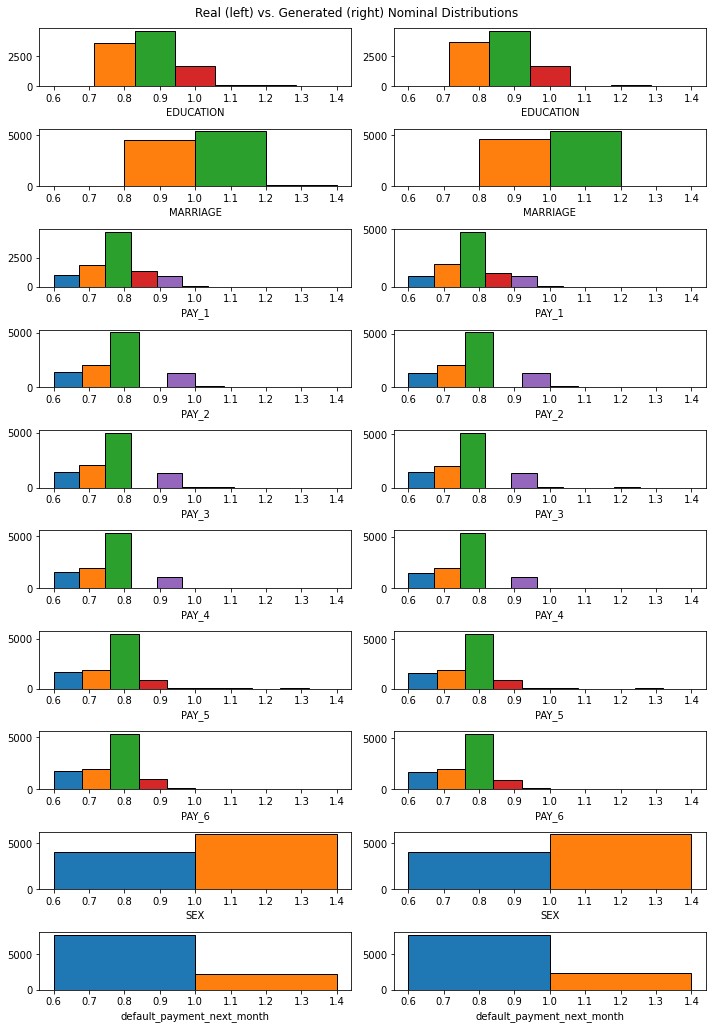

In [ ]:
fig= plt.figure(figsize=[10, 15])
dim= len(nominalColumnsValues)
idx_Xreal=np.arange(1,dim*2,2)
idx_Xfake=np.arange(2,dim*2+2,2)
for eachVariable in range(dim):
    
    plt.subplot(dim, 2, idx_Xreal[eachVariable])
    plt.hist(retransformer(XrealSeparated[eachVariable]), bins=[.5,.5,1.5], ec= 'k')
    plt.xlabel(nominalColumns[eachVariable])
    
    plt.subplot(dim, 2, idx_Xfake[eachVariable])
    plt.hist(retransformer(XfakeSeparated[eachVariable]), bins=[.5,.5,1.5], ec= 'k')
    plt.xlabel(nominalColumns[eachVariable])
    
    
    
plt.suptitle('Real (left) vs. Generated (right) Nominal Distributions');
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

## Pairwise Mutual Information of Nominal variables 
----------------

#### Nominal variables only 

In [ ]:
## Convert nominal synthetic data to condensed df 

#get all of the nominal variables (in one-hot encoded format)
nominalVariablesList = variableSeparator(nominalColumnsValues = nominalColumnsValues, nominalDataset= Xreal_nominal)
#initialize dataframe before loop
df_Xfake_nominal= pd.DataFrame()
#Tranform from one-hot encoding to original shape for each nominal variable 
for eachColumn in range(len(nominalVariablesList )):
  #create dataFrame object 
  tmp= pd.DataFrame(nominalVariablesList[eachColumn])
  #equate column names to unique values of the variable 
  uniqueValues= datasetNominal.iloc[:,eachColumn].unique()
  uniqueValues.sort() #sort values (just like ohe of sklearn does)
  tmp.columns= uniqueValues 
  #condense one-hot encoding back to original shape 
  tmp2= tmp.idxmax(axis='columns')
  #concatenate into one dataFrame containing all of the nominal columns 
  df_Xfake_nominal= pd.concat([df_Xfake_nominal, tmp2], axis= 1)
#name the columns appropriately 
df_Xfake_nominal.columns= nominalColumns


## Convert nominal real data to condensed df 

#get all of the nominal variables (in one-hot encoded format)
nominalVariablesList = variableSeparator(nominalColumnsValues = nominalColumnsValues, nominalDataset= Xfake_nominal)
#initialize dataframe before loop
df_Xreal_nominal= pd.DataFrame()
#Tranform from one-hot encoding to original shape for each nominal variable 
for eachColumn in range(len(nominalVariablesList )):
  #create dataFrame object 
  tmp= pd.DataFrame(nominalVariablesList[eachColumn])
  #equate column names to unique values of the variable 
  uniqueValues= datasetNominal.iloc[:,eachColumn].unique()
  uniqueValues.sort() #sort values (just like ohe of sklearn does)
  tmp.columns= uniqueValues 
  #condense one-hot encoding back to original shape 
  tmp2= tmp.idxmax(axis='columns')
  #concatenate into one dataFrame containing all of the nominal columns 
  df_Xreal_nominal= pd.concat([df_Xreal_nominal, tmp2], axis= 1)
#name the columns appropriately 
df_Xreal_nominal.columns= nominalColumns

In [ ]:
# ------------------------------
# Pairwise Mutual Information 
# ------------------------------

from sklearn.feature_selection import mutual_info_classif


## Real dataset 

#Initialize Pairwise Mutual Information Matrix  
PMI_real= np.empty([df_Xreal_nominal.shape[1], df_Xreal_nominal.shape[1] ])
#Compute PMI for every column of the real dataset
for eachColumn in range(0, df_Xreal_nominal.shape[1]):
  PMI_real[:, eachColumn]= mutual_info_classif(df_Xreal_nominal.values, df_Xreal_nominal.iloc[:, eachColumn], discrete_features= True)
#convert to DataFrame
PMI_real= pd.DataFrame(data= PMI_real, columns=nominalColumns, index= nominalColumns)

## Fake dataset 

#Initialize Pairwise Mutual Information Matrix  
PMI_fake= np.empty([df_Xfake_nominal.shape[1], df_Xfake_nominal.shape[1] ])
#Compute PMI for every column of the real dataset
for eachColumn in range(0, df_Xfake_nominal.shape[1]):
  PMI_fake[:, eachColumn]= mutual_info_classif(df_Xfake_nominal.values, df_Xfake_nominal.iloc[:, eachColumn], discrete_features= True)
#convert to DataFrame
PMI_fake= pd.DataFrame(data= PMI_fake, columns=nominalColumns, index= nominalColumns)

## Difference between PMI of Real and Fake dataset 
PMI_diff= PMI_real - PMI_fake
PMI_diff

,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,SEX,default_payment_next_month
EDUCATION,-0.028737,-0.003133,-0.002324,-0.001142,-0.000395,-0.002267,0.000024,0.003350,0.000275,-0.001893
MARRIAGE,-0.003133,-0.010025,0.000117,-0.000095,-0.000484,0.000739,-0.000502,0.000203,-0.000347,-0.000567
PAY_1,-0.002324,0.000117,-0.020597,-0.052829,-0.021137,-0.011008,-0.006390,0.001090,-0.002632,-0.007680
PAY_2,-0.001142,-0.000095,-0.052829,-0.030147,-0.058743,-0.020313,-0.006694,0.009390,0.000233,-0.005191
PAY_3,-0.000395,-0.000484,-0.021137,-0.058743,-0.031314,-0.066003,-0.020554,-0.005621,-0.000515,-0.000316
PAY_4,-0.002267,0.000739,-0.011008,-0.020313,-0.066003,-0.009875,-0.045871,-0.002795,-0.001299,0.000974
PAY_5,0.000024,-0.000502,-0.006390,-0.006694,-0.020554,-0.045871,-0.013226,-0.047065,-0.000908,0.000922
PAY_6,0.003350,0.000203,0.001090,0.009390,-0.005621,-0.002795,-0.047065,-0.023934,-0.001055,0.002145
SEX,0.000275,-0.000347,-0.002632,0.000233,-0.000515,-0.001299,-0.000908,-0.001055,-0.001930,-0.000719
default_payment_next_month,-0.001893,-0.000567,-0.007680,-0.005191,-0.000316,0.000974,0.000922,0.002145,-0.000719,0.008497


In [ ]:
# Frobenius norm of real dataset PMI matrix
Xreal_fro= np.linalg.norm(PMI_real, ord= 'fro')
# Frobenius norm of synthetic dataset PMI matrix 
Xfake_fro= np.linalg.norm(PMI_fake, ord= 'fro')
# Difference in norms
X_fro_diff= np.abs(Xreal_fro - Xfake_fro)
print('################################ FROBENIUS NORM #################################################')
print('-------------------------------------------------------------------------------------------------')
print("The absolute difference between the Frobenius norm of the Real and Synthetic nominal dataset PMI matrices: %.2f" %(X_fro_diff))
print('-------------------------------------------------------------------------------------------------')


################################ FROBENIUS NORM #################################################
-------------------------------------------------------------------------------------------------
The absolute difference between the Frobenius norm of the Real and Synthetic nominal dataset PMI matrices: 0.14
-------------------------------------------------------------------------------------------------


#### Entire dataset

In [ ]:
# ------------------------------
# Pairwise Mutual Information 
# ------------------------------

from sklearn.feature_selection import mutual_info_regression

## Real dataset 

#Initialize Pairwise Mutual Information Matrix  
PMI_real= np.empty([Xreal_continuous_renormalized.shape[1] + df_Xreal_nominal.shape[1], 
                    Xreal_continuous_renormalized.shape[1] + df_Xreal_nominal.shape[1]])
idx= 0
#Compute PMI for every column of the real dataset
for eachColumn in range(0, Xreal_continuous_renormalized.shape[1] + df_Xreal_nominal.shape[1]):
  if eachColumn < Xreal_continuous_renormalized.shape[1]:
    PMI_real[:, eachColumn]= mutual_info_regression(np.concatenate( (Xreal_continuous_renormalized, df_Xreal_nominal), axis= 1), 
                                                    Xreal_continuous_renormalized[:, eachColumn])
  else: 
    PMI_real[:, eachColumn]= mutual_info_classif(np.concatenate( (Xreal_continuous_renormalized, df_Xreal_nominal), axis= 1), 
                                                 df_Xreal_nominal.iloc[:, idx])
    idx+= 1

#convert to DataFrame
PMI_real= pd.DataFrame(data= PMI_real, columns= continuousColumns + nominalColumns, index= continuousColumns + nominalColumns)


## Fake dataset 

#Initialize Pairwise Mutual Information Matrix  
PMI_fake= np.empty([Xfake_continuous_renormalized.shape[1] + df_Xfake_nominal.shape[1], 
                    Xfake_continuous_renormalized.shape[1] + df_Xfake_nominal.shape[1]])
idx= 0
#Compute PMI for every column of the real dataset
for eachColumn in range(0, Xfake_continuous_renormalized.shape[1] + df_Xfake_nominal.shape[1]):
  if eachColumn < Xfake_continuous_renormalized.shape[1]:
    PMI_fake[:, eachColumn]= mutual_info_regression(np.concatenate( (Xfake_continuous_renormalized, df_Xfake_nominal), axis= 1), 
                                                    Xfake_continuous_renormalized[:, eachColumn])
  else: 
    PMI_fake[:, eachColumn]= mutual_info_classif(np.concatenate( (Xfake_continuous_renormalized, df_Xfake_nominal), axis= 1), 
                                                 df_Xfake_nominal.iloc[:, idx])
    idx+= 1

#convert to DataFrame
PMI_fake= pd.DataFrame(data= PMI_fake, columns= continuousColumns + nominalColumns, index= continuousColumns + nominalColumns)

## Difference between PMI of Real and Fake dataset 
PMI_diff= PMI_real - PMI_fake
PMI_diff

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,LIMIT_BAL,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,SEX,default_payment_next_month
AGE,-0.043210,0.755501,0.760621,0.738071,0.745935,0.684629,0.703347,0.089549,0.546335,0.446856,0.532637,0.437823,0.446724,0.468847,0.000000,0.005269,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001574,0.001519,0.001916
BILL_AMT1,0.751273,-0.605240,1.429035,1.382448,1.281663,1.166892,1.099212,0.813894,1.615414,1.360929,1.296745,1.159272,1.139911,1.169663,0.002042,-0.000087,-0.005386,-0.001096,0.000000,-0.000933,-0.002834,-0.002814,0.000000,0.000000
BILL_AMT2,0.757942,1.428515,-0.686345,1.498146,1.285053,1.182633,1.162143,0.790801,2.463215,1.454141,1.349660,1.165613,1.193038,1.185649,0.000137,0.000000,0.000000,0.000000,0.000000,0.005583,0.000000,0.000000,-0.001094,-0.006673
BILL_AMT3,0.733168,1.383687,1.491344,-0.759052,1.490403,1.283511,1.225871,0.774881,1.606870,2.264844,1.437973,1.184896,1.194896,1.190783,0.000000,0.003735,0.000000,-0.006023,-0.001643,-0.000521,-0.015288,-0.002081,0.000151,0.000000
BILL_AMT4,0.746351,1.282729,1.281442,1.490360,-0.848452,1.285031,1.182062,0.747129,1.449143,1.434042,2.171697,1.290172,1.291828,1.222368,-0.007063,0.002533,-0.003568,0.003966,-0.019900,-0.004543,-0.002924,0.005607,-0.002550,0.001808
BILL_AMT5,0.680309,1.167483,1.179685,1.273152,1.282251,-0.912839,1.284096,0.769532,1.353390,1.318435,1.383044,2.012856,1.411401,1.303442,0.002407,-0.011013,0.000000,0.001370,-0.004968,-0.010272,-0.005673,-0.011269,0.000000,-0.002001
BILL_AMT6,0.693898,1.100182,1.161277,1.227499,1.184863,1.282136,-1.013779,0.724654,1.277762,1.280544,1.342827,1.327948,2.268473,1.400978,0.000252,0.000347,0.005505,0.000000,0.000000,0.000000,0.000000,0.002129,0.000000,0.000000
LIMIT_BAL,0.100246,0.810504,0.789087,0.772115,0.750852,0.771409,0.719353,-4.395698,0.640406,0.532186,0.548666,0.516174,0.572770,0.564999,0.000000,0.000821,-0.006790,0.000000,0.001666,0.005509,-0.000433,0.000000,-0.000483,0.004204
PAY_AMT1,0.542509,1.618229,2.465025,1.605637,1.453086,1.349058,1.271282,0.645170,-1.963447,1.285060,1.157814,1.021862,0.945388,0.918380,-0.004043,0.002681,-0.008038,-0.011197,0.000000,-0.010673,-0.010004,-0.015589,0.000000,0.000000
PAY_AMT2,0.451684,1.365775,1.461644,2.258000,1.433183,1.312117,1.280940,0.536573,1.295692,-2.077615,1.207610,0.968737,0.963822,0.974161,0.000268,0.000413,0.000000,-0.006548,-0.006807,-0.001355,-0.002851,0.000000,0.000000,0.003491


In [ ]:
# Frobenius norm of real dataset PMI matrix
Xreal_fro= np.linalg.norm(PMI_real, ord= 'fro')
# Frobenius norm of synthetic dataset PMI matrix 
Xfake_fro= np.linalg.norm(PMI_fake, ord= 'fro')
# Difference in norms
X_fro_diff= np.abs(Xreal_fro - Xfake_fro)
print('################################ FROBENIUS NORM #################################################')
print('-------------------------------------------------------------------------------------------------')
print("The absolute difference between the Frobenius norm of the Real and Synthetic dataset PMI matrices: %.2f" %(X_fro_diff))
print('-------------------------------------------------------------------------------------------------')

################################ FROBENIUS NORM #################################################
-------------------------------------------------------------------------------------------------
The absolute difference between the Frobenius norm of the Real and Synthetic dataset PMI matrices: 1.64
-------------------------------------------------------------------------------------------------


### Train the model further if needed 
---------
- Go back to step 4 afterwards 

In [ ]:
wgan.fit(dataset, batch_size= batch_size, epochs= epochs, callbacks= [cbk])

## STEP 5: Save the Generator and the synthetic dataset   
-----------------------
- If model performance is satisfactory we can go ahead and save our trained Generator together with the synthetic dataset 

####  Create Pandas DataFrame of synthetic generated data
-----------

In [ ]:
#### Create Pandas DataFrame of synthetic generated data ####

## Convert continuous synthetic data to df 

df_Xfake_continuous= pd.DataFrame(data= Xfake_continuous_renormalized, columns= continuousColumns)

## Convert nominal synthetic data to df 

#get all of the nominal variables (in one-hot encoded format)
nominalVariablesList = variableSeparator(nominalColumnsValues = nominalColumnsValues, nominalDataset= Xreal_nominal)
#initialize dataframe before loop
df_Xfake_nominal= pd.DataFrame()
#Tranform from one-hot encoding to original shape for each nominal variable 
for eachColumn in range(len(nominalVariablesList )):
  #create dataFrame object 
  tmp= pd.DataFrame(nominalVariablesList[eachColumn])
  #equate column names to unique values of the variable 
  uniqueValues= datasetNominal.iloc[:,eachColumn].unique()
  uniqueValues.sort() #sort values (just like ohe of sklearn does)
  tmp.columns= uniqueValues 
  #condense one-hot encoding back to original shape 
  tmp2= tmp.idxmax(axis='columns')
  #concatenate into one dataFrame containing all of the nominal columns 
  df_Xfake_nominal= pd.concat([df_Xfake_nominal, tmp2], axis= 1)
#name the columns appropriately 
df_Xfake_nominal.columns= nominalColumns

## Merge the continuous and nominal synthetic data to one df 
df_Xfake= pd.concat([df_Xfake_continuous, df_Xfake_nominal], axis= 1)
#match the same layout of the original dataset 
df_Xfake= df_Xfake[ppnr.columns]

#### Save Generator and synthetic dataset (Jupyter Notebook)

----------------

In [ ]:
## Save the DataFrame
df_Xfake.to_csv('/content/gdrive/My Drive/Stress Testing with GANs/Datasets/ppnr_synthetic_data.csv')
## Save the trained Generator 
!mkdir -p saved_model
g_model.save('/content/gdrive/My Drive/Stress Testing with GANs/ppnr_generator_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Stress Testing with GANs/ppnr_generator_model/assets


#### Save Generator and synthetic dataset (Google Colab)
----------------

In [ ]:
## Save the DataFrame
df_Xfake.to_csv(r'C:\Users\ilias\Desktop\Statistics and Data Science\Jupyter Notebook\Yields.io\Stress Testing with GAN\ppnr_synthetic_data.csv')
## Save the trained Generator 
g_model.save(r'C:\Users\ilias\Desktop\Statistics and Data Science\Jupyter Notebook\Yields.io\Stress Testing with GAN\ppnr_generator_model')

INFO:tensorflow:Assets written to: C:\Users\ilias\Desktop\Statistics and Data Science\Jupyter Notebook\Yields.io\Stress Testing with GAN\ppnr_generator_model/assets


# (WIP) Test performance with XGBOOST 
--------------

In [ ]:
####### XGBOOST- IMPORT LIBRARIES NEEDED ##########

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score

In [ ]:
## Create one dataset consisting of real and fake data 



# --------
## Entire dataset (not post-processed)
# -------

#generate data
n_samples= len(ppnr)
Xfake, _= generate_artificial_samples(g_model, noise_dim, n_samples)
Xreal, _= generate_real_samples(dataset, n_samples)
#synthetic data gets labeled with 1
Xfake_new= np.ones((n_samples,Xfake.shape[1]+1))
Xfake_new[:,:-1]= Xfake  
#real data gets labeled with 0
Xreal_new= np.zeros((n_samples,Xfake.shape[1]+1))
Xreal_new[:,:-1]= Xreal
#combine synthetic and real data
df_XGBOOST_Entire= np.concatenate( (Xfake_new, Xreal_new), axis=0)

# --------
## Entire dataset (post-processed)
# -------

#synthetic data gets labeled with 1
Xfake_new= np.ones((n_samples, df_Xfake.shape[1]+1))
Xfake_new[:,:-1]= df_Xfake.iloc[:n_samples, :]  
#real data gets labeled with 0
Xreal_new= np.zeros((n_samples,df_Xfake.shape[1]+1))
Xreal_new[:,:-1]= ppnr
#combine synthetic and real data
df_XGBOOST_Entire_processed= np.concatenate( (Xfake_new, Xreal_new), axis=0)

# --------
## Nominal dataset (not post-processed)
# -------

#generate data
n_samples= len(ppnr)
Xfake, _= generate_artificial_samples(g_model, noise_dim, n_samples)
Xreal, _= generate_real_samples(dataset, n_samples)
Xfake_nominal= Xfake[:, dimContinuous:]
Xreal_nominal= Xreal[:, dimContinuous:]
#synthetic data gets labeled with 1
Xfake_new= np.ones((n_samples,Xfake_nominal.shape[1]+1))
Xfake_new[:,:-1]= Xfake_nominal  
#real data gets labeled with 0
Xreal_new= np.zeros((n_samples,Xreal_nominal.shape[1]+1))
Xreal_new[:,:-1]= Xreal_nominal
#combine synthetic and real data
df_XGBOOST_Nominal= np.concatenate( (Xfake_new, Xreal_new), axis=0)

# --------
## Nominal dataset (post-processed)
# -------


#synthetic data gets labeled with 1
Xfake_new= np.ones((n_samples, df_Xfake_nominal.shape[1]+1))
Xfake_new[:,:-1]= df_Xfake_nominal.iloc[:n_samples, :]  
#real data gets labeled with 0
Xreal_new= np.zeros((n_samples,df_Xfake_nominal.shape[1]+1))
Xreal_new[:,:-1]= datasetNominal
#combine synthetic and real data
df_XGBOOST_Nominal_processed= np.concatenate( (Xfake_new, Xreal_new), axis=0)


# --------
## Continuous dataset (not post-processed)
# -------

#generate data
n_samples= len(ppnr)
Xfake, _= generate_artificial_samples(g_model, noise_dim, n_samples)
Xreal, _= generate_real_samples(dataset, n_samples)
Xfake_continuous= Xfake[:,0:dimContinuous] 
Xreal_continuous= Xreal[:, 0:dimContinuous]
#synthetic data gets labeled with 1
Xfake_new= np.ones((n_samples,Xfake_continuous.shape[1]+1))
Xfake_new[:,:-1]= Xfake_continuous  
#real data gets labeled with 0
Xreal_new= np.zeros((n_samples,Xreal_continuous.shape[1]+1))
Xreal_new[:,:-1]= Xreal_continuous
#combine synthetic and real data
df_XGBOOST_Continuous= np.concatenate( (Xfake_new, Xreal_new), axis=0)


# --------
## Continuous dataset (post-processed)
# -------


#synthetic data gets labeled with 1
Xfake_new= np.ones((n_samples, df_Xfake_continuous.shape[1]+1))
Xfake_new[:,:-1]= df_Xfake_continuous.iloc[:n_samples, :]  
#real data gets labeled with 0
Xreal_new= np.zeros((n_samples,df_Xfake_continuous.shape[1]+1))
Xreal_new[:,:-1]= datasetContinuous
#combine synthetic and real data
df_XGBOOST_Continuous_processed= np.concatenate( (Xfake_new, Xreal_new), axis=0)

In [ ]:
## Train and evaluate XGBOOST using different datasets 


# Initialize loop
datasets_XGBOOST= [df_XGBOOST_Entire, df_XGBOOST_Entire_processed,
                   df_XGBOOST_Nominal, df_XGBOOST_Nominal_processed,
                   df_XGBOOST_Continuous, df_XGBOOST_Continuous_processed]

names= ['Entire dataset',  'Entire dataset + processed',
        'Nominal dataset',  'Nominal dataset + processed',
        'Continuous dataset',  'Continuous dataset + processed']

j= 0

# Main loop
for everyDataset in datasets_XGBOOST:

  ## Create train and training set 

  #get labels
  X= everyDataset[:,0:-1]
  y= everyDataset[:,-1]

  #setup train en test sets 
  seed = 1
  test_size = 0.33
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

  ## Train model and get accuracy on test set

  model = XGBClassifier()
  model.fit(X_train, y_train);

  y_pred = model.predict(X_test)
  predictions = [round(value) for value in y_pred]

  accuracy = accuracy_score(y_test, predictions)
  print("%s - Accuracy: %.2f%%" % (names[j], accuracy * 100.0))
  if j % 2 != 0:
    print('----------------------')
  j+= 1

Entire dataset - Accuracy: 49.62%
Entire dataset + processed - Accuracy: 92.28%
----------------------
Nominal dataset - Accuracy: 97.94%
Nominal dataset + processed - Accuracy: 49.56%
----------------------
Continuous dataset - Accuracy: 49.62%
Continuous dataset + processed - Accuracy: 90.38%
----------------------


In [ ]:
## Train and evaluate XGBOOST using the only continuous marginals

j= 0
for i in range(Xfake_continuous_renormalized.shape[1]):
  Xfake= Xfake_continuous_renormalized[:,i]
  ## truncation
  #Xfake= Xfake.clip(min=0)
  Xreal= Xreal_continuous_renormalized[:,i]
  Xfake_new= np.ones((10000,2))
  Xfake_new[:,:-1]= Xfake.reshape(-1,1)  
  Xreal_new= np.zeros((10000,2))
  Xreal_new[:,:-1]= Xreal.reshape(-1,1)  
  df_XGBOOST= np.concatenate( (Xfake_new, Xreal_new), axis=0)

  X= df_XGBOOST[:,0:-1]
  y= df_XGBOOST[:,-1]

  seed = 1
  test_size = 0.33
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

  model = XGBClassifier()
  model.fit(X_train, y_train);

  y_pred = model.predict(X_test)
  predictions = [round(value) for value in y_pred]

  accuracy = accuracy_score(y_test, predictions)
  print("%s: Accuracy: %.2f%%" % (continuousColumns[j], accuracy * 100.0))
  j+= 1

AGE: Accuracy: 52.68%
BILL_AMT1: Accuracy: 64.64%
BILL_AMT2: Accuracy: 65.67%
BILL_AMT3: Accuracy: 63.45%
BILL_AMT4: Accuracy: 65.92%
BILL_AMT5: Accuracy: 66.00%
BILL_AMT6: Accuracy: 63.44%
LIMIT_BAL: Accuracy: 90.48%
PAY_AMT1: Accuracy: 68.92%
PAY_AMT2: Accuracy: 70.45%
PAY_AMT3: Accuracy: 71.20%
PAY_AMT4: Accuracy: 71.65%
PAY_AMT5: Accuracy: 72.17%
PAY_AMT6: Accuracy: 72.48%


In [ ]:
## Train and evaluate XGBOOST using the only continuous marginals
print("XGBOOST Accuracy with truncated marginals")
print('---------------')
j= 0
for i in range(Xfake_continuous_renormalized.shape[1]):
  Xfake= Xfake_continuous_renormalized[:,i]
  ## truncation
  Xfake= Xfake.clip(min=0)
  Xreal= Xreal_continuous_renormalized[:,i]
  Xfake_new= np.ones((10000,2))
  Xfake_new[:,:-1]= Xfake.reshape(-1,1)  
  Xreal_new= np.zeros((10000,2))
  Xreal_new[:,:-1]= Xreal.reshape(-1,1)  
  df_XGBOOST= np.concatenate( (Xfake_new, Xreal_new), axis=0)

  X= df_XGBOOST[:,0:-1]
  y= df_XGBOOST[:,-1]

  seed = 1
  test_size = 0.33
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

  model = XGBClassifier()
  model.fit(X_train, y_train);

  y_pred = model.predict(X_test)
  predictions = [round(value) for value in y_pred]

  accuracy = accuracy_score(y_test, predictions)
  print("%s: Accuracy: %.2f%%" % (continuousColumns[j], accuracy * 100.0))
  j+= 1

XGBOOST Accuracy with truncated marginals
---------------
AGE: Accuracy: 52.68%
BILL_AMT1: Accuracy: 61.88%
BILL_AMT2: Accuracy: 65.97%
BILL_AMT3: Accuracy: 63.94%
BILL_AMT4: Accuracy: 66.56%
BILL_AMT5: Accuracy: 66.77%
BILL_AMT6: Accuracy: 57.76%
LIMIT_BAL: Accuracy: 90.48%
PAY_AMT1: Accuracy: 68.92%
PAY_AMT2: Accuracy: 70.45%
PAY_AMT3: Accuracy: 71.20%
PAY_AMT4: Accuracy: 71.65%
PAY_AMT5: Accuracy: 72.17%
PAY_AMT6: Accuracy: 72.48%


## TEST ENVIRONMENT 
------------
- Ignore this section please 

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score
from scipy import  stats
a = np.array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1])
b = np.array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1])
c= np.zeros(10)
print(stats.entropy(a) ) # entropy of 0.69, expressed in nats
print(mutual_info_classif(a.reshape(-1,1), b, discrete_features = True)) # mutual information of 0.69, expressed in nats
print(mutual_info_score(b,c)) # information gain of 0.69, expressed in nats

1.6094379124341005
[0.69314718]
2.220446049250313e-16


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #no info and warnings printed